# 前日までの値動きから当日の値動きを予測する
オープン・クローズ戦略のセットアップあるいはフィルターとして使うことを想定。

### 仮説
- 主にラリー・ウィリアムズの短期売買法に書かれていたアイディア
- TDW (trading day of week)
- TDM (trading day of month)
- 前日がアウトサイドデイの場合、前日の終値より当日の始値が低いときは上昇する確率が高い
- 前日がアウトサイドデイでかつ下げて引けた日の場合、前日の終値より当日の始値が低いときは上昇する確率が高い
- 2日連続終値が上昇し、その翌日の終値が前日の高値より高い場合、その翌日は上昇する確率が高い

### 結論
- TDWは機能しそう。
- 下げて引けたアウトサイドデイ戦略は機能しそうだけど滅多に発生しないから使うとしてもメインの戦略にはならない。
- TDMは未調査。
- それ以外はエッジなし。

In [26]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [116]:
df = pd.read_csv('./data/N225minif_2020_exchange_daily.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      3377 non-null   object
 1   始値      3377 non-null   int64 
 2   高値      3377 non-null   int64 
 3   安値      3377 non-null   int64 
 4   終値      3377 non-null   int64 
 5   出来高     3377 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 158.4+ KB


,日付,始値,高値,安値,終値,出来高
0,2006/7/18,14680,14715,14400,14400,22345
1,2006/7/19,14500,14650,14465,14560,20646
2,2006/7/20,14860,14975,14780,14975,17398
3,2006/7/21,14840,14875,14790,14820,14689
4,2006/7/24,14685,14870,14560,14775,22641


# 1. TDW: 曜日ごとに上昇傾向・下落傾向があるか
- 曜日ごとに値動き（終値 - 始値）を見ると、明らかに曜日サイクルはあるようだ。
    - 平均値動きを見ると、月曜日と金曜日は下落日で、火水木は上昇日。
    - 特に水曜日はかなり強い。
- 曜日ごとに上昇日の割合を見ると、水曜日と木曜日は上昇する確率が高い。
    - 特に水曜日は54.9%とかなり高い。
- boxplotとviolinplotから、外れ値が多く分散が大きいが、ほぼ正規分布に従っていることがわかる。

In [117]:
day_type = CategoricalDtype(categories=["Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True)
df['Day'] = df['日付'].map(lambda s: datetime.strptime(s, '%Y/%m/%d').strftime('%a')).astype(day_type)
df['CODiff'] = df['終値'] - df['始値'] # Close - Open の Diff

# 明らかに曜日ごとに上昇傾向・下落傾向があるようだ
print('\n■曜日ごとの値動き（終値 - 始値）の平均値')
print(df[['Day', 'CODiff']].groupby('Day').mean())

# 上昇日 / 全体　とその割合
df['isUp'] = df['CODiff'] > 0
print('\n■曜日ごとの上昇日とその割合')
df[['Day', 'isUp']].groupby('Day').apply(lambda x: f'{x.isUp.sum()} / {len(x.isUp)} = {100 * x.isUp.sum() / len(x.isUp):.1f}%')


■曜日ごとの値動き（終値 - 始値）の平均値
       CODiff
Day          
Mon -4.529984
Tue  3.517442
Wed  8.490566
Thu  1.989870
Fri -5.968208

■曜日ごとの上昇日とその割合


Day
Mon    318 / 617 = 51.5%
Tue    347 / 688 = 50.4%
Wed    378 / 689 = 54.9%
Thu    361 / 691 = 52.2%
Fri    356 / 692 = 51.4%
dtype: object

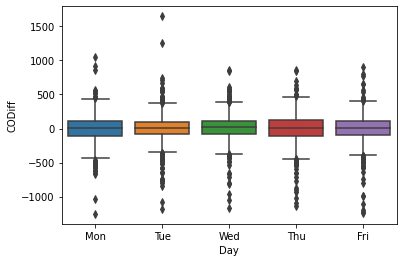

In [79]:
sns.boxplot(x='Day', y='CODiff', data=df)

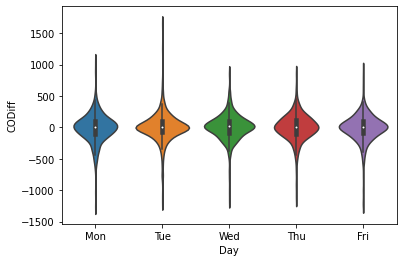

In [80]:
sns.violinplot(x=df['Day'], y=df['CODiff'])

# 2. TDM
TBD

# 3. アウトサイドデイの翌日の分析

- アウトサイドデイの発生率：8.6%

### 前日がアウトサイドデイでその終値より今日の始値が安いときに上昇するか
- 発生した割合：3.8%
- 上昇した割合：48.8%
- 総損益：1,500円
- 平均損益：11.8円

**この戦略にエッジがあるとは到底思えない。**

### 前日が下げて引けたアウトサイドデイで、かつその終値より今日の始値が安い日（より絞り込む）
- 発生した割合：1.9%
- 上昇した割合：77.8%
- 総損益：26,500円
- 平均損益：420.6円

**一応エッジはありそうだが、発生確率が低すぎる。**

In [136]:
# アウトサイドデイのデータ作成
df['始値1'] = df['始値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['高値1'] = df['高値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['安値1'] = df['安値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['終値1'] = df['終値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['Outside'] = (df['高値1'] > df['高値']) & (df['安値1'] < df['安値'])

# 翌々日
df['始値2'] = df['始値'][2:].append(pd.Series([np.nan, np.nan])).reset_index(drop=True)
df['高値2'] = df['高値'][2:].append(pd.Series([np.nan, np.nan])).reset_index(drop=True)
df['安値2'] = df['安値'][2:].append(pd.Series([np.nan, np.nan])).reset_index(drop=True)
df['終値2'] = df['終値'][2:].append(pd.Series([np.nan, np.nan])).reset_index(drop=True)

# そもそもアウトサイドデイは滅多に発生しない
print(f'アウトサイドデイの発生率：{100 * df["Outside"].sum() / df.shape[0]:.1f}%')

# 前日がアウトサイドデイで、かつその終値より今日の始値が安い日
df_setup = df[(df['Outside'] == True) & (df['始値2'] < df['終値1'])]
print(f'セットアップ日の発生率：{100 * df_setup.shape[0] / df.shape[0]:.1f}%')
df_setup['nnCODiff'] = df['終値2'] - df['始値2']
df_setup.shape

アウトサイドデイの発生率：8.6%
セットアップ日の発生率：3.8%


<ipython-input-136-c143fdd42225>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_setup['nnCODiff'] = df['終値2'] - df['始値2']


(127, 19)

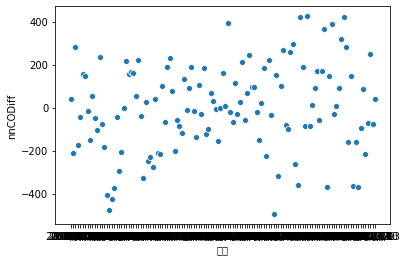

In [137]:
# 前日がアウトサイドデイで、かつその終値より今日の始値が安い日の値動き（終値 - 始値）を各日についてプロット
sns.scatterplot('日付', 'nnCODiff', data=df_setup)

In [149]:
# 前日がアウトサイドデイで、かつその終値より今日の始値が安い日の上昇確率
print(f'上昇確率：{100 * (df_setup["nnCODiff"] > 0).sum() / df_setup.shape[0]:.1f}%')

# 始値で買って終値で売った場合（現実的ではないが）の総損益
print(f'総損益：{df_setup["nnCODiff"].sum() * 100}円')

# 平均損益
print(f'平均損益：{df_setup["nnCODiff"].mean() * 100:.1f}円')

上昇確率：48.8%
総損益：1500.0円
平均損益：11.8円


In [139]:
# より絞り込んだセットアップ
# 前日が下げて引けたアウトサイドデイで、かつその終値より今日の始値が安い日
df_setup2 = df[(df['Outside'] == True) & (df['終値1'] < df['始値1']) & (df['始値2'] < df['終値1'])]
print(f'セットアップ日の発生率：{100 * df_setup2.shape[0] / df.shape[0]:.1f}%')
df_setup2['nnCODiff'] = df['終値2'] - df['始値2']
df_setup2.shape

セットアップ日の発生率：1.9%


<ipython-input-139-e349fab1c548>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_setup2['nnCODiff'] = df['終値2'] - df['始値2']


(63, 19)

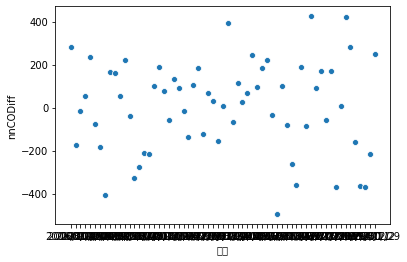

In [140]:
sns.scatterplot('日付', 'nnCODiff', data=df_setup2)

In [150]:
# 前日が下げて引けたアウトサイドデイで、かつその終値より今日の始値が安い日の上昇確率
print(f'上昇確率： {100 * (df_setup2["CODiff"] > 0).sum() / df_setup2.shape[0]:.1f}%')

# 始値で買って終値で売った場合（現実的ではないが）の総損益
print(f'総損益：{df_setup2["nnCODiff"].sum() * 100}円')

# 平均損益
print(f'平均損益：{df_setup2["nnCODiff"].mean() * 100:.1f}円')

上昇確率： 77.8%
総損益：26500.0円
平均損益：420.6円


# 4. 2日連続終値が上昇し、その翌日の終値が前日の高値より高い場合、その翌日は上昇する確率が高いか
**結論：全然ダメ。**
- 発生した割合：9.1%
- 上昇した割合：50.2%
- 総損益：-272000.0円
- 平均損益：-886.0円

In [157]:
# 5日間分のデータが必要
# 翌翌翌日
df['始値3'] = df['始値'][3:].append(pd.Series([np.nan, np.nan, np.nan])).reset_index(drop=True)
df['高値3'] = df['高値'][3:].append(pd.Series([np.nan, np.nan, np.nan])).reset_index(drop=True)
df['安値3'] = df['安値'][3:].append(pd.Series([np.nan, np.nan, np.nan])).reset_index(drop=True)
df['終値3'] = df['終値'][3:].append(pd.Series([np.nan, np.nan, np.nan])).reset_index(drop=True)

# 翌翌翌翌日
df['始値4'] = df['始値'][4:].append(pd.Series([np.nan, np.nan, np.nan, np.nan])).reset_index(drop=True)
df['高値4'] = df['高値'][4:].append(pd.Series([np.nan, np.nan, np.nan, np.nan])).reset_index(drop=True)
df['安値4'] = df['安値'][4:].append(pd.Series([np.nan, np.nan, np.nan, np.nan])).reset_index(drop=True)
df['終値4'] = df['終値'][4:].append(pd.Series([np.nan, np.nan, np.nan, np.nan])).reset_index(drop=True)


# ここでは、
# 4日前：値
# 3日前：値1
# 2日前：値2
# 1日前：値3
# 当日：値4
# として扱う

In [163]:
# 3日前と2日前に上げて引けて、かつ前日の終値が2日前の高値より高い条件
df_setup3 = df[(df['終値1'] > df['終値']) & (df['終値2'] > df['終値1']) & (df['終値3'] > df['高値2'])]
print(f'発生率：{100 * df_setup3.shape[0] / df.shape[0]:.1f}%')

# このセットアップ日の上昇確率
df_setup3['CODiff4'] = df_setup3['終値4'] - df_setup3['始値4']
print(f'上昇確率：{100 * (df_setup3["CODiff4"] > 0).sum() / df_setup3.shape[0]:.1f}%')

# 始値で買って終値で売った場合（現実的ではないが）の総損益
print(f'総損益：{df_setup3["CODiff4"].sum() * 100}円')

# 平均損益
print(f'平均損益：{df_setup3["CODiff4"].mean() * 100:.1f}円')

発生率：9.1%
上昇確率：50.2%
総損益：-272000.0円
平均損益：-886.0円


<ipython-input-163-5d522e53f01d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_setup3['CODiff4'] = df_setup3['終値4'] - df_setup3['始値4']


/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20184 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20184 missing from current font.
  font.set_text(s, 0, flags=flags)


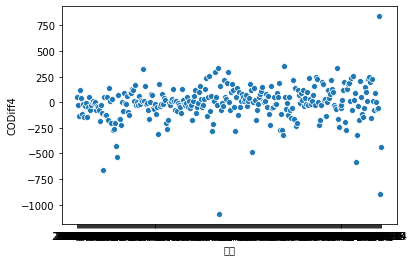

In [164]:
sns.scatterplot('日付', 'CODiff4', data=df_setup3)